# Training semantic segmentation model

This notebook is used to train an existing semantic segmentation model to our dataset. The data loader is in a separate file (`gazebo_screenshot_dataset.py`).

In [1]:
import torchvision.transforms as T
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
from torch import optim
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from collections import OrderedDict
from gazebo_screenshot_dataset import GazeboScreenshotDataset, ToTensor
import time
import copy

In [2]:
def ishow(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

In [3]:
# needed for multi-processed data loader
torch.multiprocessing.set_start_method('spawn')

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
composed = T.Compose([
    ToTensor(),
])
dataset_train = GazeboScreenshotDataset("./gazebo_data/images/", mode="train", transform=composed)
dataset_valid = GazeboScreenshotDataset("./gazebo_data/images/", mode="valid", transform=composed)

In [6]:
# check if all data has been loaded and train/validation split works as intended
len(dataset_train), len(dataset_valid)

(144, 48)

In [7]:
dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=4)
dataloader_valid = DataLoader(dataset_valid, batch_size=2, shuffle=False, num_workers=4)

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                print(".", end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)['out']
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [9]:
model = torchvision.models.segmentation.fcn_resnet50(num_classes=4).to(device)

# alternative model
# model = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=4).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [10]:
# run training

trained_model, trained_val_acc_history = train_model(
    model=model,
    dataloaders={"train": dataloader_train, "val": dataloader_valid},
    criterion=nn.CrossEntropyLoss(
        # add weight attribute if there is extreme class imbalance
        # weight=torch.Tensor([1.0, 10.0, 100.0, 100.0]).to(device)
    ),
    optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
    num_epochs=20
)

Epoch 0/19
----------
........................................................................
train Loss: 0.3150 Acc: 270986.0486
........................
val Loss: 0.1577 Acc: 287064.2500

Epoch 1/19
----------
........................................................................
train Loss: 0.1365 Acc: 290290.4444
........................
val Loss: 0.1329 Acc: 290661.8333

Epoch 2/19
----------
........................................................................
train Loss: 0.1265 Acc: 291561.0556
........................
val Loss: 0.1212 Acc: 292098.2083

Epoch 3/19
----------
........................................................................
train Loss: 0.1087 Acc: 293967.0347
........................
val Loss: 0.1138 Acc: 293079.0833

Epoch 4/19
----------
........................................................................
train Loss: 0.1014 Acc: 294751.3194
........................
val Loss: 0.1079 Acc: 293780.8125

Epoch 5/19
----------
.......................

# view some results

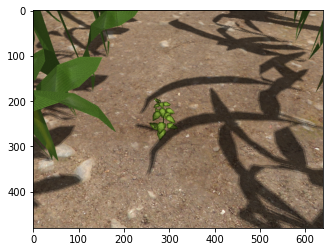

In [12]:
plt.figure()
plt.imshow(next(dataloader_valid.__iter__())[0].cpu().numpy()[0,:,:,:].swapaxes(0,2))
plt.show()

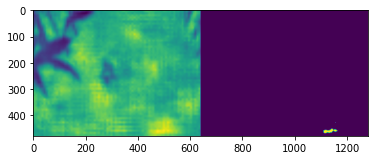

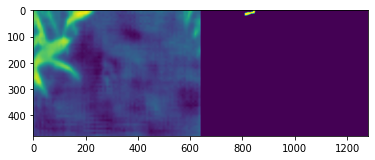

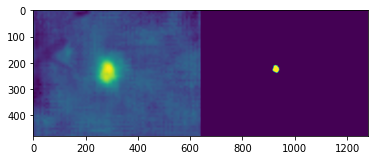

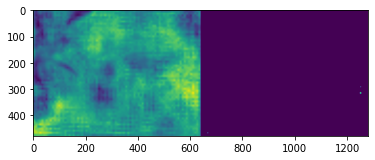

In [13]:
for class_id in range(4):
    channel = res[0,class_id,:,:].swapaxes(0,1)
    channel -= channel.min()
    channel /= channel.max()
    mask = channel >= 0.95
    combined = np.concatenate([channel, mask], axis=1)
    ishow(combined)

# onnx export

We export our model to the ONNX format for inference. An onnx file contains a standalone version of the model that can be run on any onnx capable platform for inference.

In [15]:
import torch.onnx 

In [17]:
# Export the model
torch.onnx.export(model,               # model being run
                  torch.from_numpy(next(dataloader_valid.__iter__())[0].cpu().numpy()[0,:,:,:][np.newaxis,:,:,:]).to(device), # model input (or a tuple for multiple inputs)
                  "./resources/net.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})